In [1]:
!nvidia-smi

Sun Sep  8 13:25:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install datasets
!pip install transformers==4.19.2
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requi

In [4]:
import pandas as pd
from datasets import load_metric
df=pd.read_csv("/content/articleSetfinal.csv")
df.head()

,title,summary,content
0,Mental Note Vol. 24,"Irrespective of gender, race, age or religion ...",Photo by Josh Riemer on Unsplash<|n|><|n|>Merr...
1,Your Brain On Coronavirus,These pathways converge and mediate brain heal...,Your Brain On Coronavirus<|n|><|n|>A guide to ...
2,Mind Your Nose,Learning a new language or reading more books ...,Mind Your Nose<|n|><|n|>How smell training can...
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,Passionate about the synergy between science a...
4,Surviving a Rod Through the Head,"What about him?” Well, let’s just say that he ...","You’ve heard of him, haven’t you? Phineas Gage..."


In [5]:
print("Before removing NaNs:", df.shape)
df = df.dropna()
print("After removing NaNs:", df.shape)
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

Before removing NaNs: (1072, 3)
After removing NaNs: (985, 3)
After removing duplicates: (985, 3)


In [7]:
df['length']=df.content.map(lambda x: len(x.split(" ")))


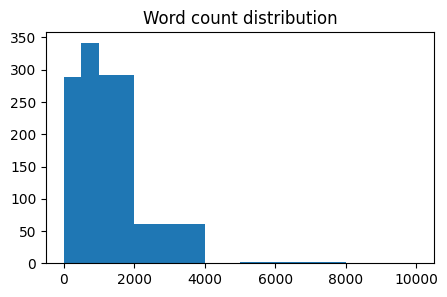

In [9]:
numOfWords=df.length
from matplotlib import pyplot as plt

fig=plt.figure(figsize=(5,3))
plt.hist(numOfWords, bins = [0,500,1000,2000,4000,5000,8000,10000])
plt.title("Word count distribution")
plt.show()

In [17]:
tempdf=df[df.length<=800]
tempdf=tempdf[tempdf.length>=100]
tempdf.shape

(505, 4)

In [18]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [19]:
max_output_length = 1024
max_input_length = 1024
batch_size = 4

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["summary"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["content"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch['global_attention_mask'] = len(batch['input_ids']) * [[0 for _ in range(len(batch['input_ids'][0]))]]

    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
    return batch

In [20]:
import numpy as np
train, validate, test = np.split(tempdf.sample(frac=1, random_state=22), [int(.6*len(tempdf)), int(.7*len(tempdf))])
print("Training:",train.shape)
print("Validation:",validate.shape)
print("Testing:",test.shape)

Training: (303, 4)
Validation: (50, 4)
Testing: (152, 4)


In [21]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
validate_dataset = Dataset.from_pandas(validate)

In [24]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["content", "summary","length","__index_level_0__"],
)

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

In [25]:
validate_dataset=validate_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["content", "summary","length","__index_level_0__"],
)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [26]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
validate_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [27]:
from transformers import AutoModelForSeq2SeqLM
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
led.config.num_beams = 2
led.config.max_length = 1024
led.config.min_length = 512
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
transformers.logging.set_verbosity_info()

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10
)

Downloading:   0%|          | 0.00/618M [00:00<?, ?B/s]

<ipython-input-27-7514b10dc8cc>:10: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [28]:
# Create the trainer object
trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validate_dataset,
    compute_metrics=compute_metrics,
)



In [29]:
trainer.train()


The following columns in the training set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 303
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 190
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will 

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,2.716000,2.531455,0.133200,0.212300,0.159100


The following columns in the evaluation set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50
  Batch size = 4
Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json
Model weights saved in ./checkpoint-10/pytorch_model.bin
tokenizer config file saved in ./checkpoint-10/tokenizer_config.json
Special tokens file saved in ./checkpoint-10/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for mor

KeyboardInterrupt: 

In [30]:
sample = tempdf.sample(frac=0.005,random_state=22)
sample.shape

(3, 4)

In [31]:
sample=sample[['content','summary']]
sample['content']

644     What if I tell you that we have been thinking ...
363     AWS — Deploying Vue App With NodeJS Backend On...
1019    Word Cloud<|n|><|n|>In this article we will tr...
Name: content, dtype: object

In [33]:
sample['summary'][363]

'Amazon Elastic Kubernetes Service (Amazon EKS) is a managed service that makes it easy for you to run Kubernetes on AWS without needing to stand up or maintain your own Kubernetes control plane.'

In [35]:
from datasets import Dataset
pubmed_test = Dataset.from_pandas(sample)
import torch
from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

# load tokenizer
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-10")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-10").to("cuda").half()



Didn't find file /content/checkpoint-10/added_tokens.json. We won't load it.
loading file /content/checkpoint-10/vocab.json
loading file /content/checkpoint-10/merges.txt
loading file None
loading file /content/checkpoint-10/special_tokens_map.json
loading file /content/checkpoint-10/tokenizer_config.json
loading configuration file /content/checkpoint-10/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder

In [36]:
def generate_answer(batch):
  inputs_dict = tokenizer(batch["summary"], padding="max_length", max_length=1024, return_tensors="pt", truncation=True)
  input_ids = inputs_dict.input_ids.to("cuda")
  attention_mask = inputs_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(attention_mask)
  global_attention_mask[:, 0] = 1
  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch["predicted_content"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch

result = pubmed_test.map(generate_answer, batched=True, batch_size=2)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [38]:
result['content'][1]

'AWS — Deploying Vue App With NodeJS Backend On EKS<|n|><|n|>A step by step guide with an example project<|n|><|n|>AWS provides more than 100 services and it’s very important to know which service you should select for your needs. Amazon Elastic Kubernetes Service (Amazon EKS) is a managed service that makes it easy for you to run Kubernetes on AWS without needing to stand up or maintain your own Kubernetes control plane. Kubernetes is an open-source system for automating the deployment, scaling, and management of containerized applications.<|n|><|n|>In this post, we are going to deploy the Vue application with the NodeJS environment. First, we dockerize our app and push that image to Amazon ECR and run that app on Amazon EKS.<|n|><|n|>Example Project<|n|><|n|>Prerequisites<|n|><|n|>Dockerize the Project<|n|><|n|>Pushing Docker Image To ECR<|n|><|n|>Create a Cluster and Worker Nodes<|n|><|n|>Configure kubectl to use Cluster<|n|><|n|>Deploy Kubernetes Objects On AWS EKS Cluster<|n|><|n|

In [39]:
result['predicted_content'][1]

'Amazon Elastic Kubernetes Service (Amazon EKS) is a managed service that makes it easy for you to run Kubernnetes on AWS without needing to stand up or maintain your own Kubernetses control plane. It’s called Elastic Cloud Service (ECS) and is a cloud-based service that allows you to manage your own AWS control plane and run your own applications on AWS. It has a built-in control plane that can be used to control the control plane of your own application. It can also be used as a control plane to control your own system. The control plane can be configured to run on AWS, and it can be set up to run as a separate control plane from your own control plane, which is why it is called an EC2 control plane (EC2). It can be installed as a command line or as a remote control. It is also called an EKS Control Plane (EKS) and can be run as an AWS Control Plane. It also has a managed control plane which can be accessed from the cloud. It supports all of the above commands. It even has a control 